## Hecho por: David Ramírez Betancourth
## C.C. 1002636667
## Ingeniería Electrónica
## Universidad Nacional de Colombia Sede Manizales

In [1]:
import matplotlib.pyplot as plt #Graficador
import numpy as np #Opearciones entre arrays
import scipy.signal as sig #métodos de señales (welch)
import scipy.stats as stats


import tensorflow as tf # Red Neuronal
from sklearn.model_selection import train_test_split #Divisor de datos de entrenamiento y testeo
from sklearn.preprocessing import MinMaxScaler #Normalizador de escala
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential #Red Neuronal
from tensorflow.keras.layers import Dense, Dropout #Conexión neuronas
from tensorflow.keras.optimizers import Adam #Optimizador de red

#Generar Señal

$f_o = 1 Hz$

$x(t) = cos(\omega_o) - \frac{sin(3\omega_o)}{3} + \frac{cos(5\omega_o)}{5}$

$\xi(t) = x(t) + \eta(t)$

Aplicar método welch: Consiste en hallar la FFT por ventaneos de la señal y luego promediando las PSD de cada segmento

In [2]:

np.random.seed(0)

def randomvector(N, sigma):
    """Genera un vector gaussiano eta = N(0, sigma)"""
    return np.random.normal(0, np.sqrt(sigma), size=N)

def real_signal(t, wo):
    """x(t)"""
    return np.cos(wo*t) - (1/3)*np.sin(3*wo*t) + (1/5)*np.cos(5*wo*t)

def welch_vector(X, fs, nperseg, window, nfft):
    """Generar psd de la señal xi
       ventaneo hamming
       overlap del 25% de la vetana
    """
    return sig.welch(X, fs, window=window, nperseg=nperseg, noverlap=(nperseg//2), nfft=nfft)

def matrix_data(t, wo, sigma, M):
    N = len(t)
    X = np.zeros((M, N))  # Ajustar la dimensión de la matriz
    for i in range(M):
        X_true = real_signal(t, wo)  # Generar señal real
        X[i] = X_true + randomvector(N, sigma)  # Combinarla con ruido, meterla a la fila
    return X

def matrix_psd(X, nperseg, window, fs, M, N, fn):

    Psd_real = np.zeros((M, N))  # Matriz para almacenar los PSD
    for i in range(M):
        f, psd = welch_vector(X[i], fs, nperseg, window, N*2-1)
        Psd_real[i] = psd
    
    return f, Psd_real

# Parámetros
N = 1024  # Longitud señal
M = 1000  # Número de señales
fo = 10  # 1Hz frecuencia
wo = 2*np.pi*fo
sigma = 0.1  # Varianza
t = np.linspace(0, 1, N)  # Vector de tiempo de 0 a 3 segundos
fs = 1/(t[1]-t[0])  # Frecuencia de muestreo
nperseg = N - 1
fn = int(5*wo+20)

# Generación de datos
X = matrix_data(t, wo, sigma, M)

# Cálculo de PSD para cada señal
f, Psd_real = matrix_psd(X, nperseg, 'blackmanharris', fs, M, N, fn)


# Preparar Datos

Scaler: normaliza los datos a una escala deseada (0,1)

train test split: Divide los datos un porcentaje deseado 70/30, 70 entrenar, 30 test.

In [46]:
scaler = MinMaxScaler(feature_range=(0, 1))

X_scaled = scaler.fit_transform(X)
Psd_scaled = scaler.fit_transform(Psd_real)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Psd_scaled, test_size=0.3, random_state=42)

# Red Neuronal

Modelo tipo Sequential(MLP): Las capas se apilan una tras otra, lo que hace que el flujo de datos sea simple y directo. Es MLP porque contiene perceptrones. Capa de entrada - capa oculta - capa de salida. Configuración Dense.

Optimizador Adam: Utiliza AdaGrad y RMSProp. Consiste en:
- Calcular Gradiente
- Se corrige sesgos
- Se actualizan pesos
 



In [47]:
model = Sequential([
    tf.keras.Input(shape=(N,)), #Capa de entrada
    Dense(N//2, activation='relu'), #Capa oculta
    Dropout(0.5), #Dropout para no sobreajuste
    Dense(N//4, activation='elu'), # Capa oculta
    Dense(128, activation='relu'), #Capa oculta
    Dense(N) #Capa de salida
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['accuracy']) #Optimizador adam, 

history = model.fit(X_train, y_train, epochs=40, validation_split=0.2)

Epoch 1/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0000e+00 - loss: 0.0642 - val_accuracy: 0.0071 - val_loss: 0.0413
Epoch 2/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.8797e-04 - loss: 0.0426 - val_accuracy: 0.0000e+00 - val_loss: 0.0397
Epoch 3/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - loss: 0.0391 - val_accuracy: 0.0000e+00 - val_loss: 0.0348
Epoch 4/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0014 - loss: 0.0353 - val_accuracy: 0.0000e+00 - val_loss: 0.0295
Epoch 5/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - loss: 0.0303 - val_accuracy: 0.0000e+00 - val_loss: 0.0253
Epoch 6/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0025 - loss: 0.0262 - val_accuracy: 0.0000e+00 - val_loss: 0.0227
Epoch 7/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0028 - loss: 0.0238 - val_accuracy: 0.0000e+00 - val_loss: 0.0213
Epoch 8/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0040 - l

# Rendimiento del Modelo

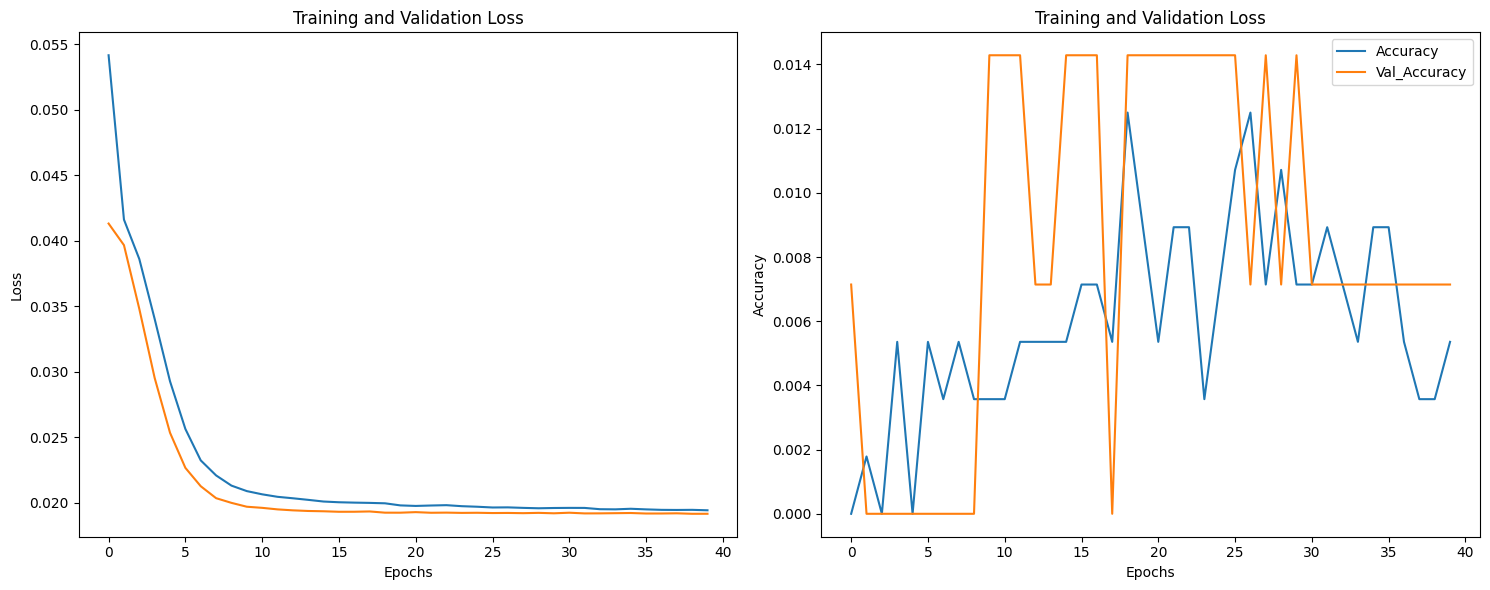

In [48]:

fig, axs = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(15, 6)
axs[0].plot(history.history['loss'], label='Training Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[1].plot(history.history['accuracy'], label='Accuracy')
axs[1].plot(history.history['val_accuracy'], label='Val_Accuracy')
axs[1].set_title('Training and Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Predecir

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


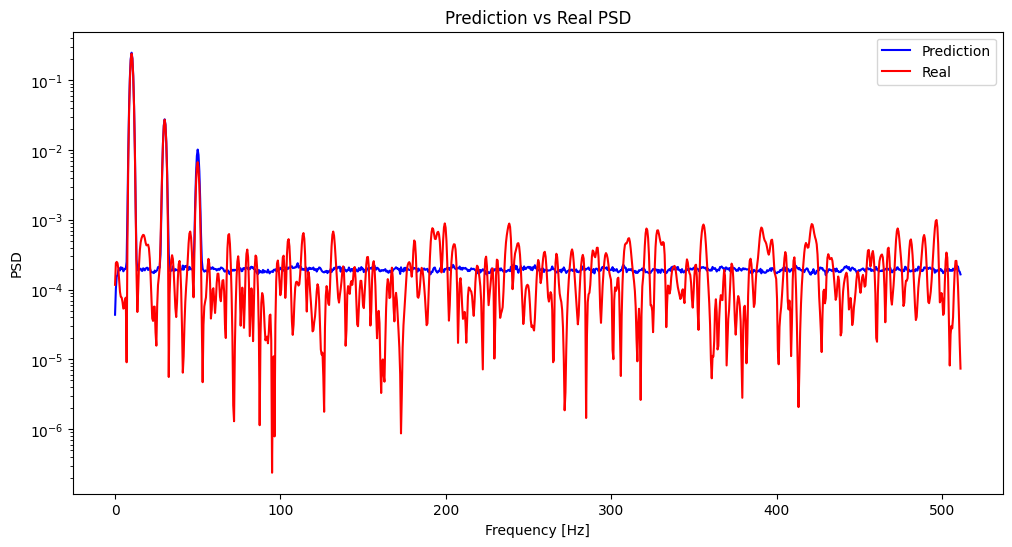

In [49]:
psd_pred_scaled = model.predict(X_scaled)
psd_pred = scaler.inverse_transform(psd_pred_scaled)

plt.figure(figsize=(12, 6))
plt.semilogy(f, psd_pred[50], color='b', label='Prediction')
plt.semilogy(f, Psd_real[50], color='r', label='Real')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD')
plt.title('Prediction vs Real PSD')
plt.legend()
plt.show()

In [7]:
"""np.random.seed(0)

def reconstruir_senal(f, psd, t):

    # Convertir la PSD en la magnitud del espectro de frecuencia
    magnitud = np.sqrt(psd)

    # Crear un espectro complejo con magnitud y fase aleatoria
    
    fase_aleatoria = np.exp(1j * np.random.uniform(0, 2 * np.pi, len(f)))
    espectro = magnitud * fase_aleatoria

    # Duplicar el espectro para considerar las frecuencias negativas
    espectro_completo = np.concatenate([espectro, np.conj(espectro[::-1])])

    # Realizar la IFFT para obtener la señal en el dominio temporal
    senal = np.fft.ifft(espectro_completo)

    # Asegurar que la señal resultante sea real
    senal_real = np.real(senal)

    return senal_real[:len(t)]

rec_real = reconstruir_senal(f, Psd_real[100], t)
rec_pred = reconstruir_senal(f,psd_pred[100], t)
t_rec = t[0:502]


plt.figure(figsize=(12,6))
plt.plot(t_rec, rec_real, label='real')
plt.plot(t_rec, rec_pred, label='pred')
plt.legend()
plt.show()"""

"np.random.seed(0)\n\ndef reconstruir_senal(f, psd, t):\n\n    # Convertir la PSD en la magnitud del espectro de frecuencia\n    magnitud = np.sqrt(psd)\n\n    # Crear un espectro complejo con magnitud y fase aleatoria\n    \n    fase_aleatoria = np.exp(1j * np.random.uniform(0, 2 * np.pi, len(f)))\n    espectro = magnitud * fase_aleatoria\n\n    # Duplicar el espectro para considerar las frecuencias negativas\n    espectro_completo = np.concatenate([espectro, np.conj(espectro[::-1])])\n\n    # Realizar la IFFT para obtener la señal en el dominio temporal\n    senal = np.fft.ifft(espectro_completo)\n\n    # Asegurar que la señal resultante sea real\n    senal_real = np.real(senal)\n\n    return senal_real[:len(t)]\n\nrec_real = reconstruir_senal(f, Psd_real[100], t)\nrec_pred = reconstruir_senal(f,psd_pred[100], t)\nt_rec = t[0:502]\n\n\nplt.figure(figsize=(12,6))\nplt.plot(t_rec, rec_real, label='real')\nplt.plot(t_rec, rec_pred, label='pred')\nplt.legend()\nplt.show()"

# Umbral adaptativo

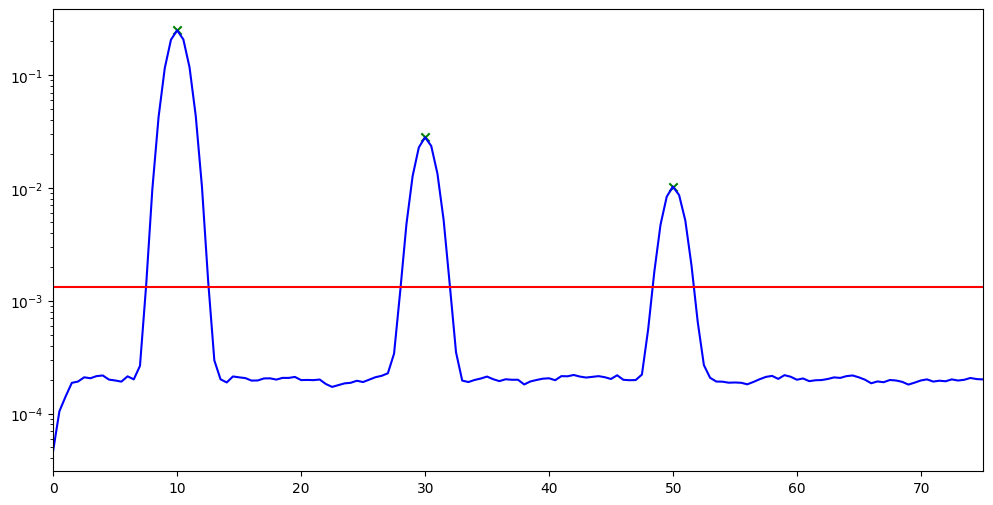

In [51]:
def harmonics(f, psd):

    psd_mean = np.mean(psd)

    peaks, _ = sig.find_peaks(psd, height=psd_mean, distance=1)

    peaks_filtered = peaks[psd[peaks] > psd_mean] #filtrar picos
    # Paso 3: Obtener las coordenadas
    harm_f = f[peaks_filtered]
    harm_psd = psd[peaks_filtered]


    return psd_mean, harm_f, harm_psd


thres, harm_f, harm_psd = harmonics(f, psd_pred[100])

plt.figure(figsize=(12,6))
plt.semilogy(f, psd_pred[100], c='b')
plt.semilogy(f, np.full(len(f), thres), c='r')
plt.scatter(harm_f, harm_psd,  marker='x', c='g')

plt.xlim([0,75])
plt.show()

# KDE Kernel density estimation

- Hallar el histograma de cada uno de los harmónicos.
- Hacerle KDE para una función limpia gaussiana

(1000, 3)


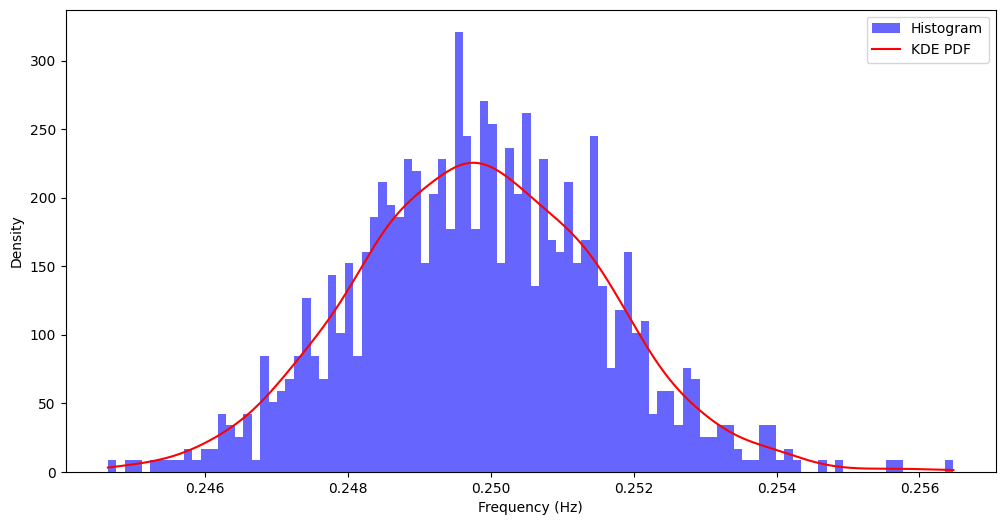

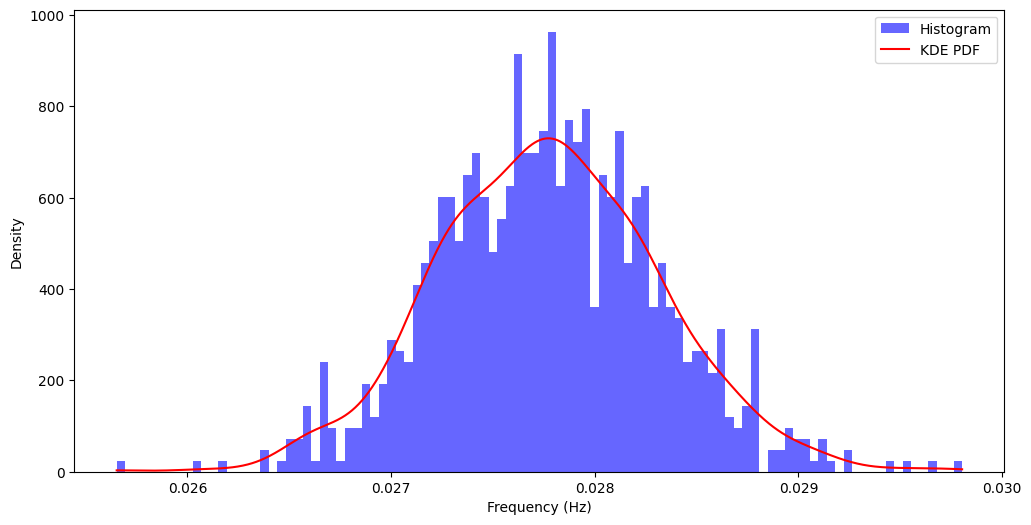

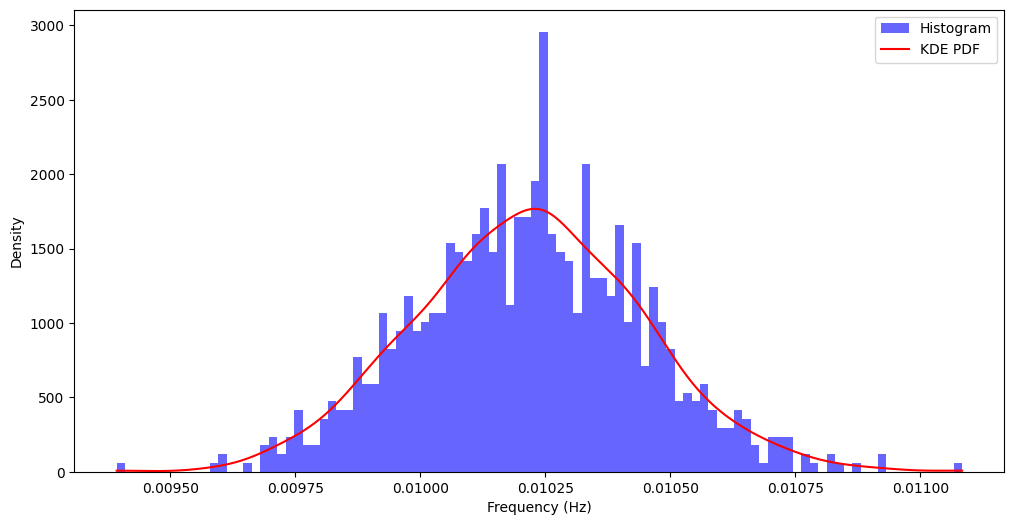

In [52]:
n_harm = 3
harmonics_vector = np.zeros((M, n_harm))

for i in range(M):
    thres, harm_f, harm_psd = harmonics(f, psd_pred[i])
    harmonics_vector[i] = harm_psd
 
print(harmonics_vector.shape)
for i in range(n_harm):

    harmonic = harmonics_vector[:,i]
    kde = stats.gaussian_kde(harmonic)
    x = np.linspace(np.min(harmonic), np.max(harmonic), 1000)
    pdf = kde(x)
    plt.figure(figsize=(12, 6))
    plt.hist(harmonic, bins=100, density=True, alpha=0.6, color='b', label='Histogram')
    plt.plot(x, pdf, c='r', label='KDE PDF')
    plt.xlabel('Frequency (Hz)') 
    plt.ylabel('Density')
    plt.legend()
    plt.show()

# Señal reconstruida mediante umbral

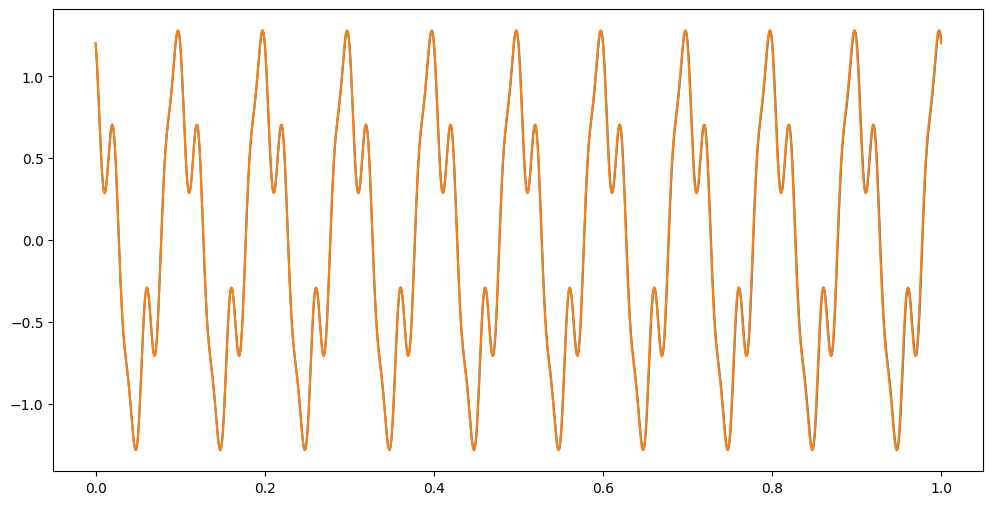

In [53]:
psd_normalized = harm_psd/(harm_psd.max())
psd_vector = np.sqrt(psd_normalized)

#Reconstruir señal

rec_signal = psd_vector[0]*np.cos(2*np.pi*harm_f[0]*t) - psd_vector[1]*np.sin(2*np.pi*harm_f[1]*t) + psd_vector[2]*np.cos(2*np.pi*harm_f[2]*t)

plt.figure(figsize=(12,6))
plt.plot(t, rec_signal)
plt.plot(t, real_signal(t,wo))
plt.show()

In [54]:
sigma = [0, 0.1, 0.2, 0.5, 1, 5, 10, 30]

# Parámetros
N = 1024  # Longitud señal
M = 1000  # Número de señales
fo = 10  # 1Hz frecuencia
wo = 2*np.pi*fo
t = np.linspace(0, 1, N)  # Vector de tiempo de 0 a 3 segundos
fs = 1/(t[1]-t[0])  # Frecuencia de muestreo
nperseg = N - 1
fn = int(5*wo+20)

mse_vector = np.zeros(len(sigma))
mae_vector = np.zeros(len(sigma))

for j in range(len(sigma)):

    X = matrix_data(t, wo, sigma[j], M)

    f, Psd_real = matrix_psd(X, nperseg, 'blackmanharris', fs, M, N, fn)

    scaler = MinMaxScaler(feature_range=(0, 1))

    X_scaled = scaler.fit_transform(X)
    Psd_scaled = scaler.fit_transform(Psd_real)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, Psd_scaled, test_size=0.3, random_state=42)

    history = model.fit(X_train, y_train, epochs=40, validation_split=0.2)

    psd_pred_scaled = model.predict(X_scaled)
    psd_pred = scaler.inverse_transform(psd_pred_scaled)

    mse_per_signal = np.zeros(M)
    mae_per_signal = np.zeros(M)
    for k in range(M):
        mse_per_signal[k] = mean_squared_error(psd_pred[k], Psd_real[k])
        mae_per_signal[k] = mean_absolute_error(psd_pred[k], Psd_real[k])




    mse_vector[j] = np.mean(mse_per_signal)
    mae_vector[j] = np.mean(mae_per_signal)


rmse_vector = np.sqrt(mse_vector)

Epoch 1/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0000e+00 - loss: 0.0019 - val_accuracy: 0.0000e+00 - val_loss: 0.0014
Epoch 2/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - loss: 0.0012 - val_accuracy: 0.0000e+00 - val_loss: 8.0092e-04
Epoch 3/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 7.1323e-04 - val_accuracy: 0.0000e+00 - val_loss: 4.9746e-04
Epoch 4/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - loss: 4.4972e-04 - val_accuracy: 0.0000e+00 - val_loss: 3.2837e-04
Epoch 5/40
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 3.0127e-04 - val_accuracy: 0.0000e+00 - val_loss: 2.2503e-04
Epoch 6/40
 8/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - loss: 2.1809e-04 

KeyboardInterrupt: 

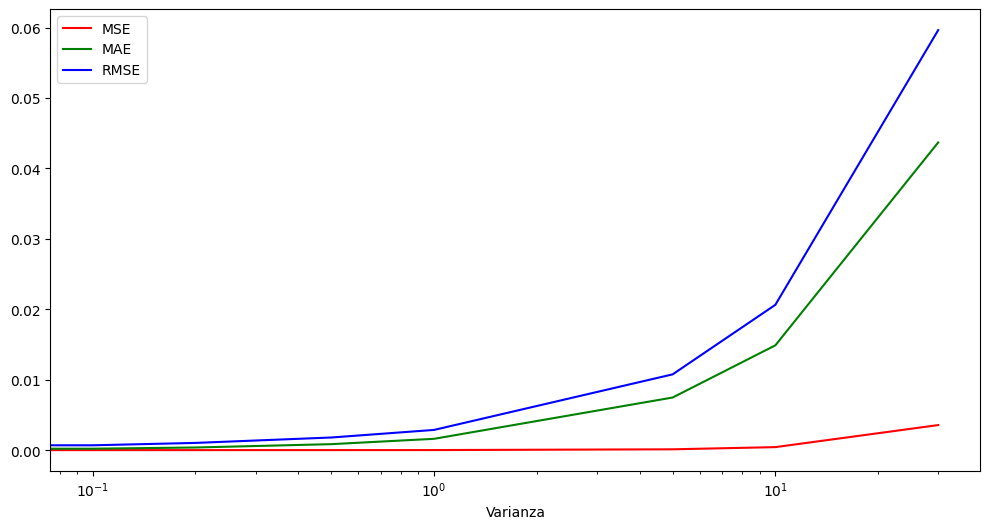

In [12]:
plt.figure(figsize=(12,6))
plt.semilogx(sigma, mse_vector, c='r', label='MSE')
plt.semilogx(sigma, mae_vector, c='g', label='MAE')
plt.semilogx(sigma, rmse_vector, c='b', label='RMSE')
plt.xlabel('Varianza')
plt.legend()
plt.show()